# Model Training

## Setting Imports And Loading Data

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import random 
random.seed(4)


df_final = pd.read_csv('../data/processed/df_final_model.csv')

In [15]:
df_final.head(2)

,processed_summary,summary_embedding,model_embedding,word_count,char_count,sentiment,category_binary,topic_1,topic_2
0,contact owns 2021 ford f 350 contact received ...,"[-0.5503813028335571, -0.2038578987121582, 0.2...","[-0.5503813028335571, -0.2038578987121582, 0.2...",77,565,-0.009091,"[0, 1, 1, 0, 0]",0.075986,0.924014
1,ford knew issue back 2021 filed agency yet wai...,"[-0.12588243186473846, 0.09368353337049484, 0....","[-0.12588243186473846, 0.09368353337049484, 0....",80,518,0.091667,"[1, 1, 0, 0, 0]",0.890972,0.109028


## Creating Topic Features

In [5]:
# Generatinhg additional features using a topic modeling 
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_final["processed_summary"])

#Model identifies two latent topics in the dataset.
topic_model = LatentDirichletAllocation(n_components=2, random_state=42)
topic_features = topic_model.fit_transform(tfidf_matrix)

topic_df = pd.DataFrame(topic_features, columns=[f"topic_{i+1}" for i in range(topic_features.shape[1])])
df_final = pd.concat([df_final, topic_df], axis=1)

In [71]:
import joblib
# Save the models
joblib.dump(tfidf, "../models/tfidf_vectorizer.pkl")
joblib.dump(topic_model, "../models/lda_model.pkl")

['../models/lda_model.pkl']

In [10]:
# Checking some correlations
df_final.drop(['processed_summary', 'sumarry_embedding', 'model_embedding', 'category_binary'], axis=1).corr()

,word_count,char_count,sentiment,is_recall,topic_1,topic_2
word_count,1.000000,0.991768,0.050435,0.208569,-0.099355,0.099355
char_count,0.991768,1.000000,0.049360,0.251131,-0.084355,0.084355
sentiment,0.050435,0.049360,1.000000,0.019249,0.298750,-0.298750
is_recall,0.208569,0.251131,0.019249,1.000000,0.271008,-0.271008
topic_1,-0.099355,-0.084355,0.298750,0.271008,1.000000,-1.000000
topic_2,0.099355,0.084355,-0.298750,-0.271008,-1.000000,1.000000


## Processing Features for Model Input

In [ ]:
# Converting columns 
df_final["category_binary"] = df_final["category_binary"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final["model_embedding"] = df_final["model_embedding"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final["summary_embedding"] = df_final["summary_embedding"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert embeddings and category binary column to NumPy arrays
X_embeddings = np.array(df_final["summary_embedding"].tolist())
y_category_binary = np.array(df_final["category_binary"].tolist())  # Ensure it's a 2D array
df_final['model_embedding'] = np.array(df_final["model_embedding"].tolist())

# Normalize additional features
additional_features = df_final[['model_embedding','word_count', 'char_count', 'sentiment', 'topic_1', 'topic_2']]
scaler = StandardScaler()
X_additional_features = scaler.fit_transform(additional_features)

# Split data into train and test sets
X_emb_train, X_emb_test, X_add_train, X_add_test, y_train, y_test = train_test_split(
    X_embeddings, X_additional_features, y_category_binary, test_size=0.2, random_state=42
)

# Verify the shapes of the data
print("X_emb_train shape:", X_emb_train.shape)  # Should match input shape for embedding input
print("X_add_train shape:", X_add_train.shape)  # Should match input shape for additional input
print("y_train shape:", y_train.shape)          # Should be (num_samples, 5) if 5 labels are expected


X_emb_train shape: (10806, 768)
X_add_train shape: (10806, 6)
y_train shape: (10806, 5)


In [67]:
import json
print("Scaler mean:", scaler.mean_)
print("Scaler scale:", scaler.scale_)

# Define mean and scale values
scaler_data = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}
# Save to JSON file
with open('../models/scaler_params.json', 'w') as f:
    json.dump(scaler_data, f)


Scaler mean: [-2.93956449e-01  5.47353420e+01  3.81603568e+02  3.34108170e-03
  6.30761131e-01  3.69238869e-01]
Scaler scale: [1.82453839e-01 3.85491054e+01 2.65486573e+02 1.80745193e-01
 3.42989438e-01 3.42989438e-01]


## Creating The Model

This model was chosen over others (BERT, RoBERTa) because it offers a simpler architecture that requires significantly less computational power. 

While transformer models can capture deeper semantic relationships, they are resource intensive. 

Our model effectively handles high-dimensional embeddings with a balance of complexity and performance, making it a practical choice for this task.


In [ ]:
# The model uses two input branches: embeddings from complaint texts and structured features. 
# Gaussian noise and dropout improve generalization, while dense layers with batch normalization stabilize learning.
# The dual-input approach enhances predictions by leveraging both semantic and contextual information. 
# Optimizations like learning rate scheduling, early stopping, and model checkpointing prevent overfitting.


# Define inputs
embedding_input = Input(shape=(X_emb_train.shape[1],), name="embedding_input")
additional_input = Input(shape=(X_add_train.shape[1],), name="additional_input")

# Add Gaussian Noise to the embedding input
x1 = GaussianNoise(0.01)(embedding_input)  # Adding noise

# Embedding branch with batch normalization and L2 regularization
x1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

# Additional features branch with batch normalization and L2 regularization
x2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(additional_input)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)

# Combine both branches
combined = Concatenate()([x1, x2])
combined = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.3)(combined)

# Output layer for multi-label classification
output = Dense(5, activation='sigmoid')(combined)

# Define the model
model = Model(inputs=[embedding_input, additional_input], outputs=output)

optimizer = Adam(learning_rate=0.00015)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Recall','Precision'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define the path to save the best model
best_model_path = "../models/best_model.h5"

# Add the ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,  # Path to save the model
    monitor='val_loss',        # Monitor the validation loss
    save_best_only=True,       # Save only when the validation loss improves
    mode='min',                # Save when the monitored metric is minimized
    verbose=1                  # Print message when saving the model
)


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Métrica a ser monitorada
    factor=0.25,          # Reduz o learning rate pela metade
    patience=3,          # Reduz o LR após 3 épocas sem melhoria
    min_lr=1e-6          # Limite mínimo para o learning rate
)
# Train the model
history = model.fit(
    {"embedding_input": X_emb_train, "additional_input": X_add_train},
    y_train,
    validation_data=({"embedding_input": X_emb_test, "additional_input": X_add_test}, y_test),
    epochs=200,
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)


Epoch 1/200
80/85 [===========================>..] - ETA: 0s - loss: 3.4594 - accuracy: 0.2725 - auc: 0.5789 - recall: 0.5758 - precision: 0.2979
Epoch 1: val_loss improved from inf to 3.04923, saving model to best_model.h5
85/85 [==============================] - 2s 14ms/step - loss: 3.4444 - accuracy: 0.2748 - auc: 0.5818 - recall: 0.5785 - precision: 0.3001 - val_loss: 3.0492 - val_accuracy: 0.3553 - val_auc: 0.6760 - val_recall: 0.4066 - val_precision: 0.4137 - lr: 1.5000e-04
Epoch 2/200
85/85 [==============================] - ETA: 0s - loss: 2.9323 - accuracy: 0.3728 - auc: 0.6675 - recall: 0.6537 - precision: 0.3500
Epoch 2: val_loss improved from 3.04923 to 2.64076, saving model to best_model.h5
85/85 [==============================] - 1s 10ms/step - loss: 2.9323 - accuracy: 0.3728 - auc: 0.6675 - recall: 0.6537 - precision: 0.3500 - val_loss: 2.6408 - val_accuracy: 0.3305 - val_auc: 0.7173 - val_recall: 0.5180 - val_precision: 0.4119 - lr: 1.5000e-04
Epoch 3/200
83/85 [=======

## Plotting the training results

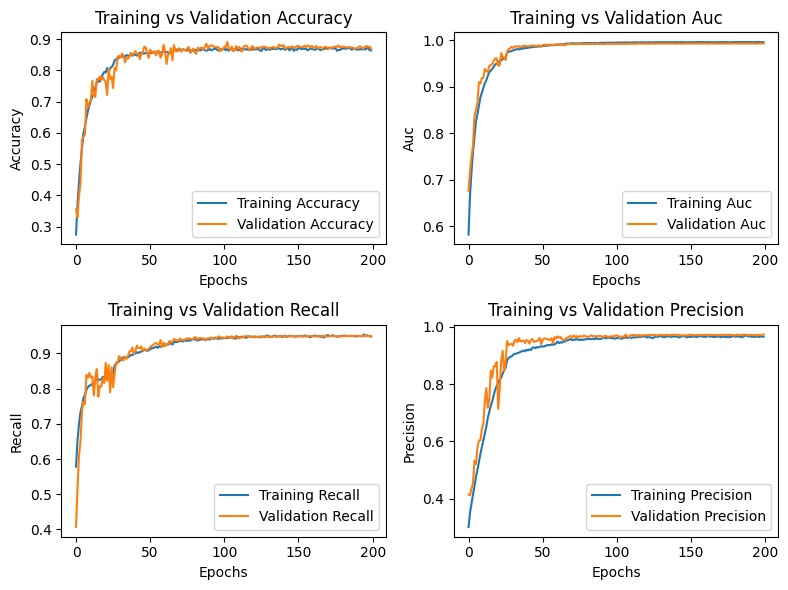

In [61]:
# Define the metrics to plot
metrics = ['accuracy', 'auc', 'recall', 'precision']

# Create subplots for each metric
plt.figure(figsize=(8, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of plots
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'Training vs Validation {metric.capitalize()}')
    
plt.tight_layout()
plt.show()


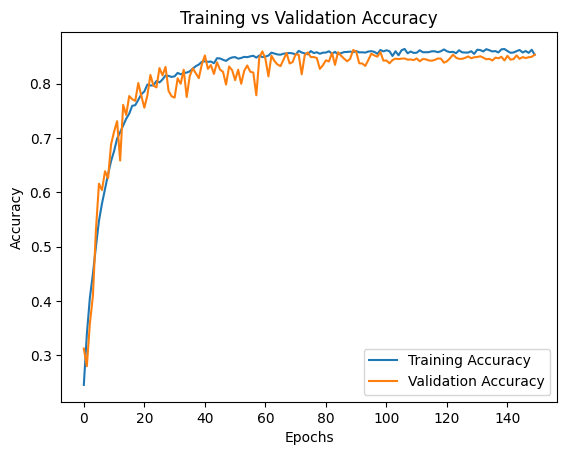

In [50]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


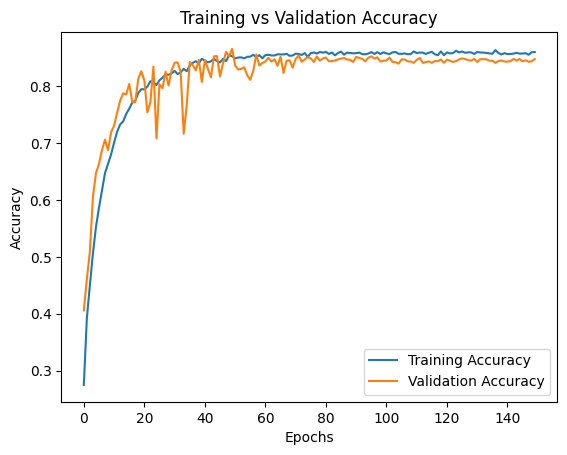

In [40]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


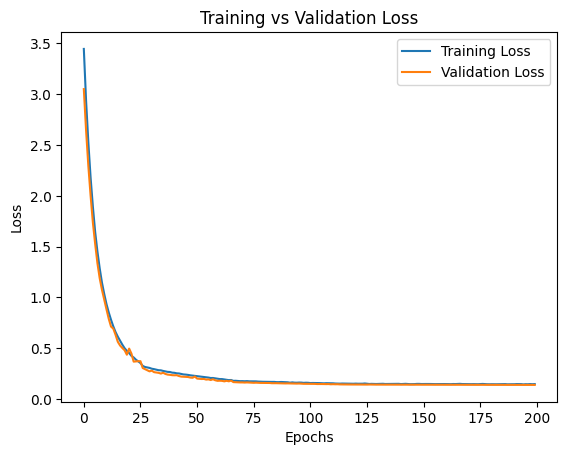

In [52]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


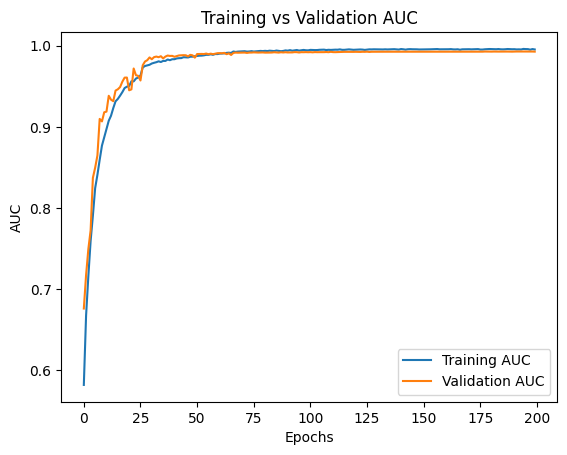

In [53]:
# Plot training and validation accuracy
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Training vs Validation AUC')
plt.show()

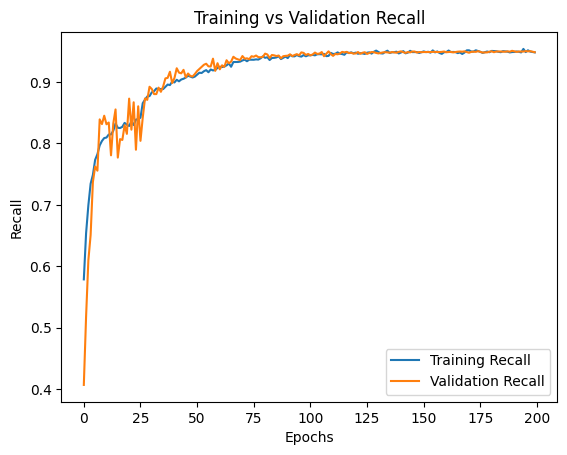

In [54]:
# Plot training and validation accuracy
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Training vs Validation Recall')
plt.show()

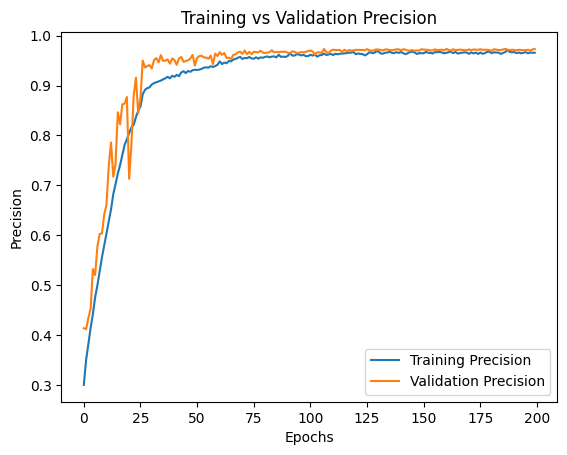

In [55]:
# Plot training and validation accuracy
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Training vs Validation Precision')
plt.show()

## Visualizing  And Evaluating The Model Performance For Each Class

In [56]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Generate predictions
y_pred = model.predict({"embedding_input": X_emb_test, "additional_input": X_add_test})
y_pred = (y_pred > 0.5).astype(int)

# Multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display classification report
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))


85/85 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Class 1       0.98      0.96      0.97       855
     Class 2       0.98      0.97      0.97      1047
     Class 3       0.97      0.93      0.95       733
     Class 4       0.98      0.94      0.96       336
     Class 5       0.97      0.93      0.95       548

   micro avg       0.97      0.95      0.96      3519
   macro avg       0.97      0.95      0.96      3519
weighted avg       0.97      0.95      0.96      3519
 samples avg       0.97      0.96      0.96      3519



c:\Users\dighz\anaconda3\envs\ford_case_iel\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


After evaluating the F1-score, recall and precision metrics we can see that it is not favoring larger categories in a significant way.

Therefore, it is not necessary to apply balancing techniques.

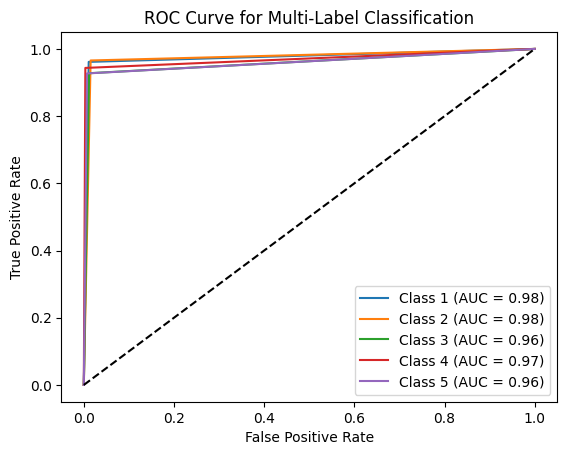

In [57]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output (for multi-label ROC)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Label Classification')
plt.legend(loc='lower right')
plt.show()
